# 네이버 영화 리뷰 감성 분류하기

네이버 영화 리뷰 감성 분류하기(https://wikidocs.net/44249)를 참고하여 연습한 딥러닝 예제

In [40]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import io
import json

## 데이터 가져오기 

In [2]:
train_data= pd.read_table("../data/ratings_train.txt")
test_data= pd.read_table("../data/ratings_test.txt")

## 데이터 살펴보기 

In [3]:
print(len(train_data)) # 학습시킬 데이터 개수

150000


In [4]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print(len(test_data)) # 평가를 위한 데이터 개수

50000


In [6]:
test_data[:5] # 상위 5개 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


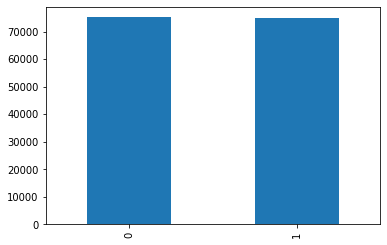

In [7]:
train_data['label'].value_counts().plot(kind='bar') # 학습데이터에서 label 값의 분포

In [8]:
train_data.groupby('label').size().reset_index(name='count') # 위 내용을 테이블로 보기

,label,count
0,0,75173
1,1,74827


## Null 값 지우기 

In [9]:
train_data.isnull().values.any() # Null 값이 있는지 확인 (결과: True/False)

True

In [10]:
train_data.loc[train_data.document.isnull()] # Null 값이 있는 레코드 출력

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [11]:
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거

In [12]:
train_data.isnull().values.any() # Null 값이 있는지 확인 (결과: True/False)

False

In [13]:
len(train_data) # Null 값이 있던 3개 레코드가 지우졌는지 확인

149995

## 전처리 수행하기 

알파벳과 공백을 제외하고 모두 제거(구두점이나 특수문자 제거)

**예시1** 영문에서 알파벳과 공백만 남기기

In [14]:
text='do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

**예시2** 한글에서 한글과 공백만 남기기

  * ㄱ-ㅎ: 3131-314E
  * ㅏ-ㅣ: 314F-3163
  * 가-힣: AC00-D7A3

UNICODE 표 참고

자음모음(ㄱ-ㅎ, ㅏ-ㅣ):https://www.unicode.org/charts/PDF/U3130.pdf

완성형 한글(가-힣): https://www.unicode.org/charts/PDF/UAC00.pdf

In [15]:
text="아 더빙.. 진짜 짜증나네요 목소리"
text.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","") #알파벳과 공백을 제외하고 모두 제거


'아 더빙.. 진짜 짜증나네요 목소리'

In [16]:
type(train_data['document'])

pandas.core.series.Series

In [17]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


## 토큰화와 불용어 제거 

In [18]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 정의 (지속적으로 검토하여 정의할 수 있음)

토큰화를 위해 형태소분석기 KoNLPy의 Okt를 사용

`stem=True`는 일부 단어를 정규화 해준다. 예를 들어 '이런'이 '이렇다'로 변환되고, '만드는'이 만들다로 변환된다.

In [19]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [20]:
X_train=[]
for sentence in train_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [21]:
print(X_train[:3]) # 상위 3개 출력

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [22]:
# 평가데이터에도 동일하게 적용
test_data=test_data.dropna(how='any') # Null 값 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

X_test=[]
for sentence in test_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

## 정수 인코딩 진행

각 샘플 데이터에 단어 데신 인덱트를 부여함

In [23]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
print(X_train[:3]) # 상위 3개만 보기

[[50, 457, 16, 260, 660], [919, 459, 41, 599, 1, 214, 1455, 24, 965, 676, 19], [386, 2452, 25024, 2319, 5676, 2, 221, 9]]


In [41]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

리뷰의 길이 살펴보기

 * 가장 긴 리뷰는 69
 * 평균적으로 10 정도의 길이를 가짐

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.64700156671889


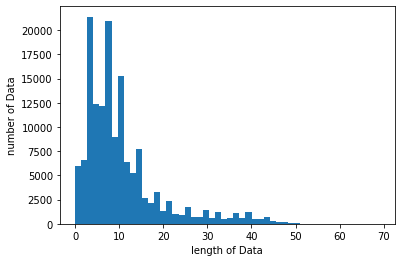

In [25]:
# len()은 list에서 element의 개수
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

모델이 처리할 수 있도록 X_train과 X_test의 길이를 **30**으로 맞춘다.

In [26]:
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [27]:
X_train[0] # 변경된 데이터 살펴보기

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  50,
       457,  16, 260, 660])

label을 별도로 y_train과 y_test에 저장

In [28]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])
print(y_train,y_test)

[0 1 0 ... 0 1 0] [1 0 0 ... 0 0 0]


In [29]:
y_train

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

## LSTM으로 영화리뷰 감성 분류하기

In [30]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [31]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=60, validation_split=0.2)

Train on 119996 samples, validate on 29999 samples
Epoch 1/4
119996/119996 [==============================] - 137s 1ms/sample - loss: 0.3894 - acc: 0.8224 - val_loss: 0.3500 - val_acc: 0.8454
Epoch 2/4
119996/119996 [==============================] - 149s 1ms/sample - loss: 0.3274 - acc: 0.8572 - val_loss: 0.3372 - val_acc: 0.8531
Epoch 3/4
119996/119996 [==============================] - 136s 1ms/sample - loss: 0.3023 - acc: 0.8707 - val_loss: 0.3337 - val_acc: 0.8559
Epoch 4/4
119996/119996 [==============================] - 135s 1ms/sample - loss: 0.2804 - acc: 0.8822 - val_loss: 0.3298 - val_acc: 0.8563


테스트 정확도 측정

In [32]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

49997/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


 테스트 정확도: 0.8527


## 데이터 입력해서 출력결과 보기

훈련데이터 3번째 '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아' 는 결과가 0.01440848 이기때문에 부정적

In [38]:
predict_in=X_train[3]
predict_in=(np.expand_dims(predict_in,0))
print(type(predict_in))
print(predict_in)
predictation_single=model.predict(predict_in)
print(predictation_single)

<class 'numpy.ndarray'>
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 6500  105 8133  219   56    4
    25 3617]]
[[0.02244723]]


## 모델 저장하기

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.save('model_file.h5')